In [1]:
# Colab usually has these, but just in case:
!pip install scikit-learn matplotlib


  Using cached scikit_learn-1.7.1-cp313-cp313-macosx_10_13_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.3.2-cp313-cp313-macosx_10_13_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.16.1-cp313-cp313-macosx_10_14_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.1-cp313-cp313-macosx_10_13_x86_64.whl (9.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 9.3 MB/s  0:00:00 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.9 MB/s  0:00:00 eta 0:00:01m
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached numpy-2.3.2-cp313-cp313-macosx_10_13_x86_64.whl (20.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 11.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 6.9 MB/s  0:00:05 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [matplotlib]2 [matplotlib

In [3]:
pip install pandas

  Using cached pandas-2.3.2-cp313-cp313-macosx_10_13_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.2-cp313-cp313-macosx_10_13_x86_64.whl (11.5 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [4]:
import re, math, pickle
import numpy as np
import pandas as pd
from urllib.parse import urlparse, unquote
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, auc
)


Matplotlib is building the font cache; this may take a moment.


In [6]:
# Replace with your filename if different
df = pd.read_csv("malicious_phish.csv", on_bad_lines="skip", low_memory=False)[["url", "type"]]
df = df.rename(columns={"type": "label"})
df["url"] = df["url"].astype(str).str.strip()
df["label"] = df["label"].astype(str).str.strip()
df = df.dropna(subset=["url","label"]).drop_duplicates(subset=["url","label"]).reset_index(drop=True)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (641125, 2)


,url,label
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [7]:
shorteners = {"bit.ly","goo.gl","t.co","ow.ly","tinyurl.com","is.gd","buff.ly","adf.ly","bitly.com","cutt.ly",
              "rebrand.ly","lnkd.in","s.id","youtu.be","v.gd","shorte.st","trib.al","rb.gy"}

suspicious_tokens = {"secure","account","login","verify","update","bank","free","bonus","lucky","gift",
                     "promo","confirm","ebay","paypal","signin","apple","microsoft","support","help",
                     "alert","unlock","win","urgent","limited","cancel","invoice","payment","wallet"}

ip_regex = re.compile(r"(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)")

def shannon_entropy(s: str) -> float:
    if not s: return 0.0
    counts = Counter(s); n = len(s)
    return -sum((c/n) * math.log2(c/n) for c in counts.values())

def extract_features(u: str):
    try:
        u = unquote(u)
        parsed = urlparse(u if "://" in u else "http://" + u)
        scheme = (parsed.scheme or "").lower()
        netloc = (parsed.netloc or "").lower()
        path = parsed.path or ""
        query = parsed.query or ""
        fragment = parsed.fragment or ""

        if "@" in netloc:
            _,_, host = netloc.rpartition("@")
            netloc = host
        host = netloc.split(":")[0]

        port_present = 1 if (":" in netloc and netloc.split(":")[-1].isdigit()) else 0
        host_parts = [p for p in host.split(".") if p]
        subdomain_count = max(len(host_parts) - 2, 0)
        tld = host_parts[-1] if host_parts else ""
        url_no_scheme = u.split("://",1)[-1]

        digits = sum(ch.isdigit() for ch in u)
        letters = sum(ch.isalpha() for ch in u)
        specials = sum(not ch.isalnum() for ch in u)
        params = len([p for p in query.split("&") if p]) if query else 0
        suspicious_count = sum(1 for tok in suspicious_tokens if tok in u.lower())

        return {
            "url_length": len(u), "host_length": len(host), "path_length": len(path), "query_length": len(query),
            "fragment_length": len(fragment), "count_dots_host": host.count("."), "count_hyphens_host": host.count("-"),
            "count_hyphens_total": u.count("-"), "count_digits": digits, "count_letters": letters, "count_specials": specials,
            "ratio_digits": digits/max(1,len(u)), "ratio_letters": letters/max(1,len(u)), "num_params": params,
            "path_depth": path.count("/"), "has_at_symbol": 1 if "@" in url_no_scheme else 0,
            "has_ip_in_host": 1 if ip_regex.fullmatch(host or "") else 0, "has_port": port_present,
            "is_https_scheme": 1 if scheme == "https" else 0, "https_in_string": 1 if "https" in u.lower() else 0,
            "double_slash_count": u.count("//"), "double_slash_last_pos": u.rfind("//"), "subdomain_count": subdomain_count,
            "tld_length": len(tld), "shortener_domain": 1 if any(s in host for s in shorteners) else 0,
            "suspicious_token_count": suspicious_count, "url_entropy": shannon_entropy(u),
            "host_entropy": shannon_entropy(host), "path_entropy": shannon_entropy(path), "query_entropy": shannon_entropy(query),
            "has_equal_in_query": 1 if "=" in query else 0, "has_exclamation": 1 if "!" in u else 0,
            "has_ip_like_anywhere": 1 if ip_regex.search(u) else 0,
        }
    except:
        return {}


In [8]:
# Encode labels
df["label_norm"] = df["label"].str.lower().str.strip()
df["y"], class_names = pd.factorize(df["label_norm"])
class_mapping = {i:c for i,c in enumerate(class_names)}
print("Classes:", class_mapping)

# Feature engineering
feat_df = df["url"].apply(extract_features).apply(pd.Series).fillna(0.0)
X = feat_df.values.astype(float)
y = df["y"].values
feature_names = list(feat_df.columns)

print("Feature matrix shape:", X.shape)


Classes: {0: 'phishing', 1: 'benign', 2: 'defacement', 3: 'malware'}
Feature matrix shape: (641125, 33)


In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)


Train: (448787, 33) Valid: (96169, 33) Test: (96169, 33)


In [10]:
rf = RandomForestClassifier(
    n_estimators=150, max_depth=20, min_samples_leaf=2,
    class_weight="balanced_subsample", random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)


,n_estimators,150
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
y_valid_pred = rf.predict(X_valid)
y_valid_proba = rf.predict_proba(X_valid)

acc = accuracy_score(y_valid, y_valid_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_valid, y_valid_pred, average="weighted")
print("Validation Acc:", round(acc,4), "Prec:", round(prec,4), "Rec:", round(rec,4), "F1:", round(f1,4))
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

cm = confusion_matrix(y_valid, y_valid_pred)
print("\nConfusion Matrix:\n", cm)

roc_auc = roc_auc_score(y_valid, y_valid_proba, multi_class="ovr", average="weighted")
print("ROC-AUC (Validation):", round(roc_auc,4))


Validation Acc: 0.9441 Prec: 0.9486 Rec: 0.9441 F1: 0.9455

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83     14114
           1       0.98      0.95      0.96     64212
           2       0.95      0.99      0.97     14296
           3       0.98      0.91      0.95      3547

    accuracy                           0.94     96169
   macro avg       0.92      0.94      0.93     96169
weighted avg       0.95      0.94      0.95     96169


Confusion Matrix:
 [[12577   974   515    48]
 [ 3313 60762   132     5]
 [   43    26 14219     8]
 [  196    22    91  3238]]
ROC-AUC (Validation): 0.9921


In [12]:
y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)

acc_t = accuracy_score(y_test, y_test_pred)
prec_t, rec_t, f1_t, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")
print("Test Acc:", round(acc_t,4), "Prec:", round(prec_t,4), "Rec:", round(rec_t,4), "F1:", round(f1_t,4))

roc_auc_t = roc_auc_score(y_test, y_test_proba, multi_class="ovr", average="weighted")
print("ROC-AUC (Test):", round(roc_auc_t,4))


Test Acc: 0.9434 Prec: 0.9481 Rec: 0.9434 F1: 0.9448
ROC-AUC (Test): 0.9918


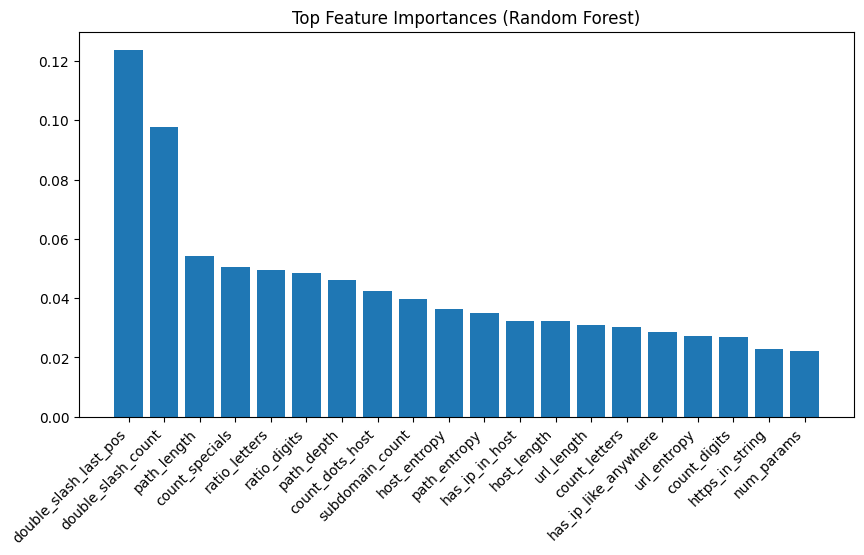

In [13]:
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10,5))
plt.title("Top Feature Importances (Random Forest)")
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=45, ha="right")
plt.show()


In [14]:
bundle = {"model": rf, "feature_names": feature_names, "class_mapping": class_mapping}
with open("rf_url_model.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("Model saved as rf_url_model.pkl")


Model saved as rf_url_model.pkl


In [18]:
def predict_url(url):
    feats = pd.DataFrame([extract_features(url)]).fillna(0.0)
    X_new = feats[feature_names].values.astype(float)
    proba = rf.predict_proba(X_new)[0]
    pred_class = np.argmax(proba)
    return {
        "url": url,
        "predicted": class_mapping[pred_class],
        "proba": dict(zip([class_mapping[i] for i in range(len(proba))], proba))
    }

# Example
print(predict_url("amtrakcalifornia.com/index.cfm/routes/san-joaquin/"))


{'url': 'amtrakcalifornia.com/index.cfm/routes/san-joaquin/', 'predicted': 'benign', 'proba': {'phishing': np.float64(0.0150550189079045), 'benign': np.float64(0.8988668816710915), 'defacement': np.float64(0.0), 'malware': np.float64(0.08607809942100406)}}
